### IMPORTANDO AS BIBLIOTECAS

In [15]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

### LEITURA DA BASE DE DADOS

In [60]:
df = pd.read_parquet("../data/processed/sim_2006_2019_balanced.parquet") 

### VISUALIZAÇÃO DA BASE DE DADOS

In [61]:
df

,ESC,ESTCIV,IDADE,NATURAL,OCUP,RACACOR,MASCULINO,FEMININO,SUICIDIO
0,-1.265136,-0.098897,-0.681432,35,-0.349768,-0.821243,True,False,0
1,-0.452366,-0.866754,-0.773146,-2,-0.350081,0.075662,True,False,0
2,-0.858751,-0.610802,-0.746942,23,-0.349768,-0.821243,True,False,0
3,-0.858751,-0.354849,-0.666146,35,-0.349768,0.075662,False,True,0
4,-0.045981,-0.866754,-0.821187,35,-0.350583,0.075662,False,True,0
...,...,...,...,...,...,...,...,...,...
272141,0.883106,-0.013550,0.458591,17,2.317550,1.573697,False,True,1
272142,0.883106,-0.013550,1.482442,17,-0.350726,1.573697,False,True,1
272143,1.422930,0.435613,1.041427,17,2.317550,-0.028454,True,False,1
272144,1.007264,0.435613,1.015236,17,-0.350726,1.573697,True,False,1


### BALANCEAMENTO DA BASE DE DADOS EM CASOS DE SUICÍDIO

In [62]:
suicidio_0 = df[df['SUICIDIO'] == 0]
suicidio_1 = df[df['SUICIDIO'] == 1]

suicidio_0_sample = suicidio_0.sample(n=len(suicidio_1), replace=False)

balanced_df = pd.concat([suicidio_0_sample, suicidio_1], ignore_index=True).reset_index(drop=True)

#### Definindo X e Y de acordo com a base de dados balanceada

In [63]:
X = balanced_df[['ESC', 'ESTCIV', 'IDADE' ,	'NATURAL' ,	'OCUP',	'RACACOR'	,'MASCULINO',	'FEMININO'	]].values
Y = balanced_df['SUICIDIO'].values

#### Divisão entre teste e treino 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=666)

### TREINANDO O MODELO
Modelo escolhido: Centróides.
Como nossa base de dados já apresenta os dados de suicídio, não foi necessária a clusterização. Portanto, os centróides de clusters podem ser utilizados para identificar os pontos centrais. Cada centróide representa os aspectos gerais de uma determinada classe.

In [65]:
modelo_prototipos = NearestCentroid()

In [66]:
modelo_prototipos.fit(X_train, y_train)

NearestCentroid()

### PREVISÃO DO MODELO TREINADO E ACURÁCIA

In [67]:
y_pred = modelo_prototipos.predict(X_test)

In [68]:
relatorio = classification_report(y_test, y_pred)
matriz = confusion_matrix(y_test, y_pred)

In [69]:
print("Relatório de Classificação:\n", relatorio)
print("Matriz de Confusão:\n", matriz)

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.61      0.41      0.49     27062
           1       0.56      0.75      0.64     27368

    accuracy                           0.58     54430
   macro avg       0.59      0.58      0.56     54430
weighted avg       0.59      0.58      0.56     54430

Matriz de Confusão:
 [[10965 16097]
 [ 6962 20406]]


### VISUALIZAÇÃO DOS DADOS

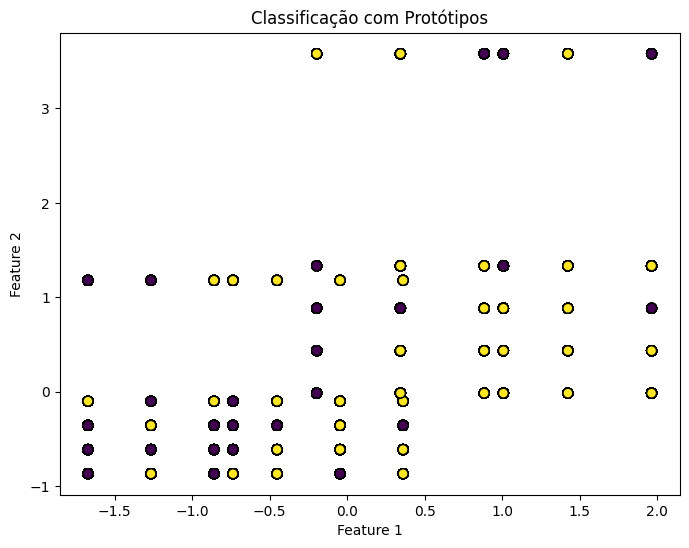

In [70]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', edgecolor='black', s=50)
plt.title('Classificação com Protótipos')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [71]:
geovanna = pd.DataFrame({'ESC': 5,    'ESTCIV': 1,    'IDADE': 22,    'NATURAL': 53,    'OCUP': -1,    'RACACOR': 4,    'MASCULINO': False,    'FEMININO': True}, index=[0])

arthur = pd.DataFrame({'ESC': 5,    'ESTCIV': 1,    'IDADE': 21,    'NATURAL': 52,    'OCUP': -1,    'RACACOR': 1,    'MASCULINO': True,    'FEMININO': False}, index=[0])



doug = pd.DataFrame({'ESC': 4,    'ESTCIV': 2,    'IDADE': 34,    'NATURAL': 29,    'OCUP': 5132,    'RACACOR': 4,    'MASCULINO': True,    'FEMININO': False}, index=[0])



cozinheiro = pd.DataFrame({'ESC': 4,    'ESTCIV': 2,    'IDADE': 34,    'NATURAL': 29,    'OCUP': 5132,    'RACACOR': 4,    'MASCULINO': True,    'FEMININO': False}, index=[0])


In [72]:
teste = pd.concat((geovanna, arthur, doug, cozinheiro), ignore_index=True)

std = StandardScaler()
columns = ['ESC', 'ESTCIV', 'IDADE', 'OCUP', 'RACACOR']
teste[columns] = std.fit_transform(teste[columns])
x = teste[['ESC', 'ESTCIV', 'IDADE', 'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']].values

In [73]:
y_pred = modelo_prototipos.predict(x)
y_pred


array([1, 1, 1, 1])